In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utilities import visualize_classifier
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [300]:
#убираем лишние колонки
data = pd.read_excel('hackaton_data.xlsx',header=0)
data.drop('Postamat_trend', axis=1, inplace=True)
data.drop('cashbox_MAX', axis=1, inplace=True)
data.drop('cashbox_trend', axis=1, inplace=True)
#заменяем отсутствующие данные на 0
data.fillna(0, inplace=True)
#если есть рядом станция, то заменяем значение на 1, если нет - на 0
data.loc[data.NEAR_Stations!=0, 'NEAR_Stations'] = 1
#убираем адрес
data.drop('ADDRESS', axis=1, inplace=True)
data.drop('CITY', axis=1, inplace=True)
data.drop('REGION', axis=1, inplace=True)
#для предсказания для кассы
train_c = data.loc[data.cashbox_daily!=0]
predict_c = data.loc[data.cashbox_daily==0]

In [301]:
x_train_num_c = np.array(predict_c.iloc[:,0:1]) #список индексов строк, для которых будем предсказывать
#убираем лишние данные для входных значений
x_train_c = train_c.iloc[:,3:] 
x_predict_c = predict_c.iloc[:,3:]
y_train_c = train_c['cashbox_daily']

In [302]:
#создаем и тренируем модель
rf = RandomForestRegressor(min_samples_leaf=1)
rf.fit(x_train_c, y_train_c)

C:\Users\irisc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [303]:
#вычисление среднеквадратичного отклонения
sqrt(mean_squared_error(rf.predict(x_train_c), y_train_c))

0.34637148065968

Text(0, 0.5, 'Estimated Cashbox_daily')

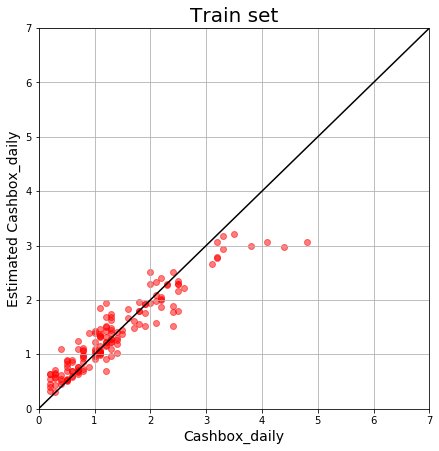

In [304]:
#построение графика для предсказанных и реальных тренировочных данных
plt.figure(figsize(7,7))
pyplot.scatter(np.array(y_train_c), rf.predict(x_train_c), color="red", alpha=0.5)
pyplot.xlim(0,7)
pyplot.ylim(0,7)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Cashbox_daily', fontsize=14)
pyplot.ylabel('Estimated Cashbox_daily', fontsize=14)

In [305]:
y_predict_c = rf.predict(x_predict_c)

In [306]:
#новый датасет для предсказания для почтаматов
new_data = pd.read_excel('hackaton_data.xlsx',header=0)
new_data.drop('Postamat_trend', axis=1, inplace=True)
new_data.drop('cashbox_MAX', axis=1, inplace=True)
new_data.drop('cashbox_trend', axis=1, inplace=True)
new_data.fillna(0, inplace=True)
new_data.loc[data.NEAR_Stations!=0, 'NEAR_Stations'] = 1

#добавление в таблицу полученных ранее прогнозов для касс
k=0
for i in range(new_data.shape[0]):
    if i in x_train_num_c:
        new_data.loc[i,'cashbox_daily']=y_predict_c[k]
        k = k + 1

In [307]:
#тренировочные данные для предсказания для постамата
train_p = new_data.loc[data.Postamat_daily!=0]
predict_p = new_data.loc[data.Postamat_daily==0]
x_train_num_p = np.array(predict_p.iloc[:,0:1])
x_train_p = train_p.iloc[:,5:]
x_predict_p = predict_p.iloc[:,5:]
y_train_p = train_p['Postamat_daily']

In [308]:
#построение и обучение
rfp = RandomForestRegressor(min_samples_leaf=1)
rfp.fit(x_train_p, y_train_p)
sqrt(mean_squared_error(rfp.predict(x_train_p), y_train_p))

C:\Users\irisc\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5667892024377317

Text(0, 0.5, 'Estimated postamat_daily')

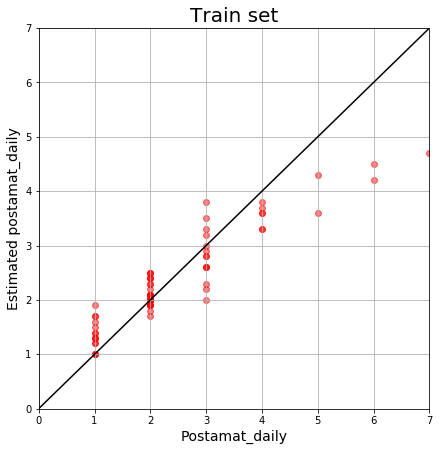

In [309]:
plt.figure(figsize(7,7))
pyplot.scatter(np.array(y_train_p), rfp.predict(x_train_p), color="red", alpha=0.5)
pyplot.xlim(0,7)
pyplot.ylim(0,7)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Postamat_daily', fontsize=14)
pyplot.ylabel('Estimated postamat_daily', fontsize=14)

In [310]:
y_predict_p = rfp.predict(x_predict_p)
k=0
#добавляем в таблицу предсказанные данные для почтаматов
for i in range(new_data.shape[0]):
    if i in x_train_num_p:
        new_data.loc[i,'Postamat_daily']=y_predict_p[k]
        k = k + 1
#новая колонка, 3 - прогноз для магазина и по кассам, и по почтаматам; 2 - только по кассам; 1 - только по почтаматам
new_data['Change']=0
for i in range(new_data.shape[0]):
    if (i in x_train_num_p) and (i in x_train_num_c):
        new_data.loc[i,'Change'] = 3
    elif (i in x_train_num_c):
        new_data.loc[i,'Change'] = 2
    elif (i in x_train_num_p):
        new_data.loc[i,'Change'] = 1 

In [315]:
#создание новой таблицы для записи только тех магазинов, где спрогнозированы рентабельные почтаматы
p = np.array(new_data.Postamat_daily)
total = pd.DataFrame({'Address':'','City':'','Region':'', 'Postamat_daily':[0]})
mean_p = np.mean(p)
for i in range(new_data.shape[0]):
    if ((new_data.loc[i,'Change']==3)|(new_data.loc[i,'Change']==1))&(new_data.loc[i,'REGION']=='Тульская область'):
        if new_data.loc[i,'Postamat_daily']>mean_p:
            addr = new_data.loc[i,'ADDRESS']
            new_line = {'Address':addr, 'City':new_data.loc[i,'CITY'], 'Region':new_data.loc[i,'REGION'], 'Postamat_daily':new_data.loc[i,'Postamat_daily']}
            total = total.append(new_line,ignore_index=True)         
total.to_csv('Total.csv', sep=',' ,header=True, index=False)